# Beatmap Visual Analysis

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import datetime as dt

In [2]:
# mongodb
from pymongo import MongoClient
client = MongoClient('localhost:27017')
db = client['Beatmaps']

In [3]:
### constants
# fields
doc = db['standard'].find_one({})
fields = list(doc.keys())
fields.remove('_id')

modes = ['standard', 'taiko', 'catch', 'mania']


In [4]:
### data frame of data
def getDataFrame(mode, approved_status=1):
    """"""
    collection = db[mode]
    data = [doc for doc in collection.find({'approved': approved_status})]
    data_frame = pd.DataFrame(data)
    
    return data_frame
        

In [5]:
def getMode(data_frame):
    """function gets the mode of a data_frame data set
    @param data_frame (pd.DataFrame) - pandas data frame
    @return mode (str) - osu! game mode
    """
    mode_index = int( data_frame['mode'][0] )
    mode = modes[mode_index]
    
    return mode
    

# Star Rating

In [6]:
### star difficulty analysis
# distribution
def analyzeStarDiff(data_frame, bulk=False, graph_type='kdeplot'):
    """"""
    mode = getMode(data_frame)
    
    if not bulk:
        if graph_type == 'kdeplot':
            ax = sns.kdeplot(data['difficultyrating'], shade=True, color='b', legend=False)
            
        elif graph_type == 'distplot':
            ax = sns.distplot(data['difficultyrating'], kde=True)
                    
        else:
            raise ValueError("Invalid 'graph_type' parameter.")
        
        ax.set_title("Distribution of Star Difficulties of Beatmaps in osu!{}".format(mode), fontsize=18)
        ax.set_ylabel("Distribution")
        ax.set_xlabel("Star Difficulty")

        # resizing y ticks ### kde by definition has to be normalized (cant have count on y-axis)
#         resize = lambda x: round((x * data['difficultyrating'].size) / 500) * 500
#         resizeFunc = np.vectorize(resize)
#         y_ticks = ax.get_yticks()
#         # y_ticks = resizeFunc(y_ticks)
#         # ax.set_yticks(y_ticks)

        # x ticks
        ax.set_xticks(np.arange(0,10))
        
        ax.xaxis.set_major_locator(MultipleLocator(1.000))
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
        
    else: # bulk by star (int) i.e. 2, 3, 4, 5 star (categorical)
        star_diffs_ints = data['difficultyrating'].astype('int64')

        ax = sns.countplot(y=star_diffs_ints, data=None)
        ax.set_title("Beatmap counts per Star Rating osu!{}".format(mode), fontsize=18)
        ax.set_xlabel("Number of Beatmaps")
        ax.set_ylabel("Star Difficulty")


C:\Users\camen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


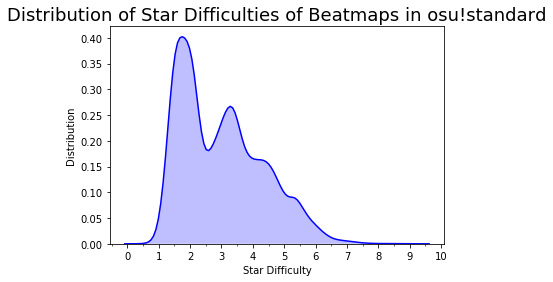

In [7]:
data = getDataFrame(mode='standard', approved_status=1)
analyzeStarDiff(data, bulk=False, graph_type='kdeplot')

C:\Users\camen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


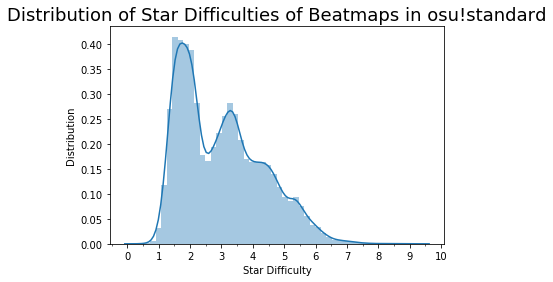

In [8]:
data = getDataFrame(mode='standard', approved_status=1)
analyzeStarDiff(data, bulk=False, graph_type='distplot')

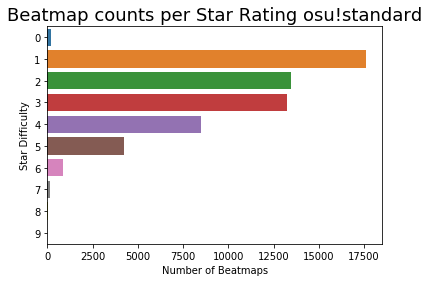

In [9]:
analyzeStarDiff(data, bulk=True)

# Length

In [10]:
# look at total_length vs. hit_length
def analyzeLength(data_frame, graph_type='kdeplot'):
    """"""
    length_data = data_frame['total_length']
    # length_data_trim = length_data.sort_values(axis=0, ascending=False)[trim_count:]

    if graph_type == 'kdeplot':
        # kde plot
        ax = sns.kdeplot(data=length_data, shade=True, color='b', legend=False)
        
    elif graph_type == 'distplot':
        # distplot plot
        ax = sns.distplot(length_data)
        
    else:
        raise ValueError("Invalid parameter for 'graph_type'.")
    
    ax.set_title("Distribution of Beatmap Lengths in osu!{}".format(getMode(data_frame)), fontsize=18)
    ax.set_ylabel("Distribution")
    ax.set_xlabel("Time in Seconds")
    
    ax.xaxis.set_major_locator(MultipleLocator(60.000))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    
    ax.set_xlim(0, 480)
    
    ax.tick_params(which='major', width=1.0, length=10)
    ax.tick_params(which='minor', width=1.0, length=5, labelsize=10)
    
    

    

C:\Users\camen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


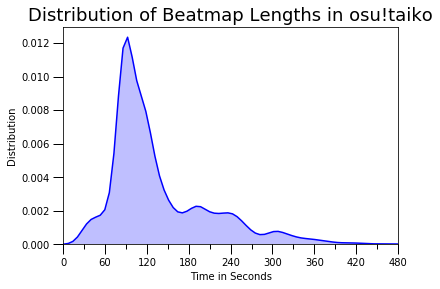

In [11]:
data = getDataFrame('taiko', approved_status=1)
analyzeLength(data, graph_type='kdeplot')

# Genre and Language

In [12]:
def sortLabels(data_series, labels):
    """"""
    sorted_labels = []
    data_count = data_series.value_counts()
    data_sort = data_count.sort_values(ascending=False)
    
    for index, val in data_sort.iteritems():
        sorted_labels.append(labels[index])
        
    return sorted_labels

def truncateData(df, name_id, threshold_percent=1.00):
    """all labels that that make up less than 1%, put them into an 'other category'
    """
    if name_id not in "language_id genre_id":
        raise ValueError("Invalid name_id parameter.")
    
    initial_size = sum(df['count'])
    other_id = int( df[df['name'] == 'other'][name_id] )
    
    df = df[df['percent'] >= threshold_percent]
    df = df[df['name'] != 'other']
    
    resize = sum(df['count'])
    other_count = initial_size - resize
    other_percent = round(((other_count / initial_size) * 100), 2)

    df.loc[len(df.index)] = [other_id, other_count, 'other', other_percent]
    
    return df

def getGenreOrLanguageDF(data_frame, field):
    """"""
    if field == 'genre':
        genres = ['any', 'unspecified', 'video_game', 'anime', 'rock', 'pop', 'other', 'novelty', None, 'hip_hop', 'electronic']
        labels = genres
        name_id = 'genre_id'
    elif field == 'language':
        languages = ['any', 'other', 'english', 'japanese', 'chinese', 'instrumental', 'korean', 'french', 'german', 'swedish', 'spanish', 'italian']
        labels = languages
        name_id = 'language_id'
    else:
        raise ValueError("Invalid field parameter.")
    
    ### counts column
    data_series = data_frame[name_id]
    data_counts = data_series.value_counts()
    df = pd.DataFrame(data_counts)
    df.columns = ['count']
    
    ### name column
    names = sortLabels(data_series, labels)
    df['name'] = names
    
    ### percent column
    percentFunc = lambda x: round((x / data_series.size) * 100, 2)
    percents = list(map(percentFunc, df['count']))
    df['percent'] = percents
    
    ### reset index
    df = df.reset_index()
    
    ### genre_id column
    df = df.rename(columns={'index': name_id})
    
    return df

In [13]:
def analyzeGenre(df):
    """"""
    genres = ['any', 'unspecified', 'video_game', 'anime', 'rock', 'pop', 'other', 'novelty', None, 'hip_hop', 'electronic']
    
    genre_df = getGenreOrLanguageDF(df, 'genre')
    
    genre_df = truncateData(genre_df, 'genre_id')
    print(genre_df)
    
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    ax = plt.pie(x=genre_df['percent'], labels=genre_df['name'], shadow=True, startangle=90)
    # ax.set_title("Genres in osu!{}".format(getMode(data_frame)))
    plt.axis('equal')
    

In [14]:
def analyzeLanguage(df):
    """"""
    languages = ['any', 'other', 'english', 'japanese', 'chinese', 'instrumental', 'korean', 'french', 'german', 'swedish', 'spanish', 'italian']
    
    lang_df = getGenreOrLanguageDF(df, 'language')
    
    lang_df = truncateData(lang_df, 'language_id')
    print(lang_df)
    
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))
    ax = plt.pie(x=lang_df['percent'], labels=lang_df['name'], shadow=True, startangle=90)
    # ax.set_title("Genres in osu!{}".format(getMode(data_frame)))
    plt.axis('equal')
    

   genre_id  count        name  percent
0         2   2302  video_game    49.44
1         3   1174       anime    25.21
2        10    645  electronic    13.85
3         7    176     novelty     3.78
4         5    155         pop     3.33
6         6    117       other     2.51


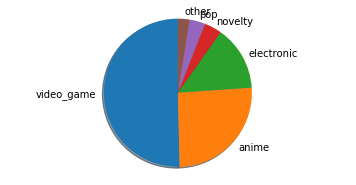

In [15]:
data = getDataFrame('mania')
analyzeGenre(data)

   language_id  count          name  percent
0            5   2309  instrumental    49.59
1            3   1914      japanese    41.11
2            2    290       english     6.23
4            1     91         other     1.95


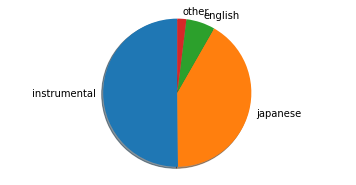

In [16]:
data = getDataFrame('mania')
analyzeLanguage(data)

# Date

In [17]:
def getQuarter(date):
    """
    # Example Date: '2007-10-06 17:46:31'
    """
    month = date[5:7]
    if month in "01 02 03":
        return '1'
    elif month in "04 05 06":
        return '2'
    elif month in "07 08 09":
        return '3'
    elif month in "10 11 12":
        return '4'
    else:
        raise ValueError("Invalid 'date' paramter.")

def getBi(date):
    """
    # Example Date: '2007-10-06 17:46:31'
    """
    month = date[5:7]
    if month in "01 02 03 04 05 06":
        return '1'
    elif month in "07 08 09 10 11 12":
        return '2'
    else:
        raise ValueError("Invalid 'date' parameter.")

In [18]:
def analyzeDate(df, time='years'):
    """"""
    date_data = df['approved_date']
    
    if time == 'year':
        years_data = [date[:4] for date in date_data]
        ax = sns.countplot(x=years_data)
        
        
    elif time == 'bi':
        bi_data = []
        for date in date_data:
            year = date[:4]
            bi = getBi(date)
            bi_d = year + '_' + bi
            bi_data.append(bi_d)
        
        ax = sns.countplot(x=bi_data)
    
    
    elif time == 'quarter':
        quarter_data = []
        for date in date_data:
            year = date[:4]
            quarter = getQuarter(date)
            quarter_d = year + '_' + quarter
            quarter_data.append(quarter_d)
        
        ax = sns.countplot(x=quarter_data)
        
    elif time == 'month':
        months_data = [date[:7] for date in date_data]
        ax = sns.countplot(x=months_data)

    else:
        raise ValueError("Invalid 'time' parameter.")
    
    #print(df)
    

In [33]:
def analyzeTime(df):
    """"""
    date_data = df['approved_date']
    start_date = date_data[0]
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    
    time_data = []
    for date in date_data:
        date = dt.datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
        difference = (date - start_date).total_seconds()
        time_data.append(difference)

    sns.kdeplot(data=time_data, shade=True, color='b', legend=False)

C:\Users\camen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


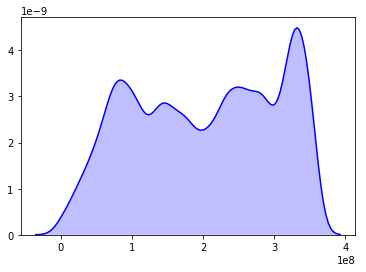

In [34]:
df = getDataFrame('standard')
analyzeTime(df)

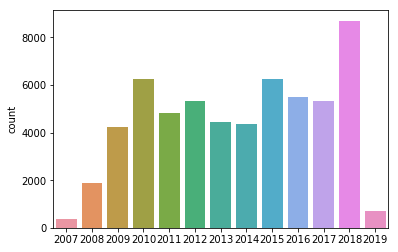

In [21]:
df = getDataFrame('standard')
analyzeDate(df, time='year')

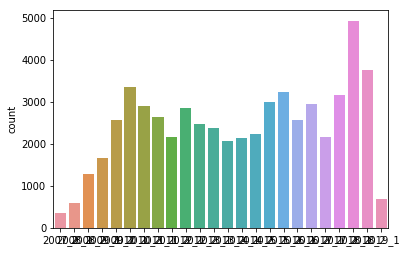

In [22]:
analyzeDate(df, time='bi')

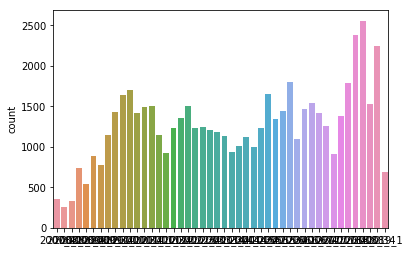

In [23]:
analyzeDate(df, time='quarter')

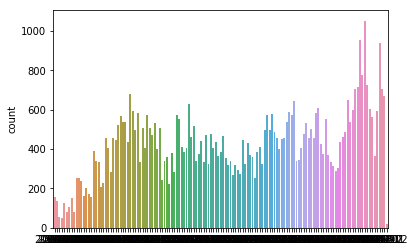

In [24]:
analyzeDate(df, time='month')

# Circle Size (CS)

In [95]:
def analyzeCS(df):
    cs_data = df['diff_size']
    ax = sns.kdeplot(data=cs_data, shade=True)
    
    ax.set_xticks(np.arange(0,10,1))
    
    ax.set_xlabel("Circle Size (CS)")
    ax.set_ylabel("Distribution")
    ax.set_title("Circle Size distribution of ranked maps in osu!{}".format(getMode(df)), fontsize=18)

C:\Users\camen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


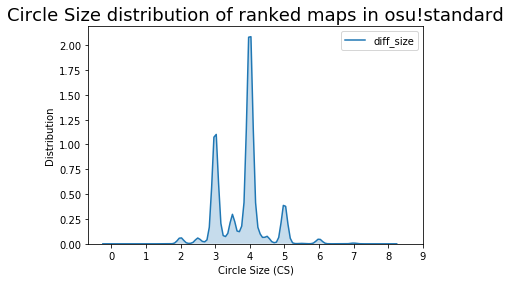

In [96]:
analyzeCS(getDataFrame('standard'))

# Overall Difficulty (OD)

In [153]:
def analyzeOD(df, tight=True):
    od_data = df['diff_overall']
    if tight:
        ax = sns.kdeplot(data=od_data, shade=True, bw=0.075)
    else:
        ax = sns.kdeplot(data=od_data, shade=True)

    ax.set_xticks(np.arange(0,12,1))
    
    ax.set_xlabel("Overall Difficuly (OD)")
    ax.set_ylabel("Distribution")
    ax.set_title("Overall Difficulty distribution of ranked maps in osu!{}".format(getMode(df)), fontsize=18)

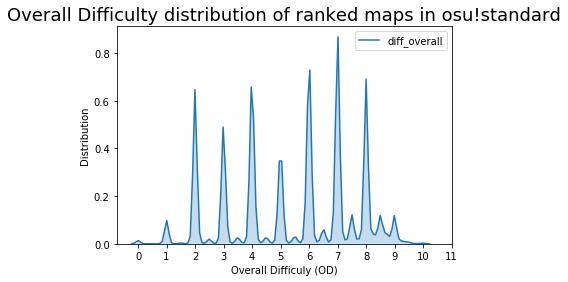

In [163]:
analyzeOD(getDataFrame('standard'), tight=True)

C:\Users\camen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


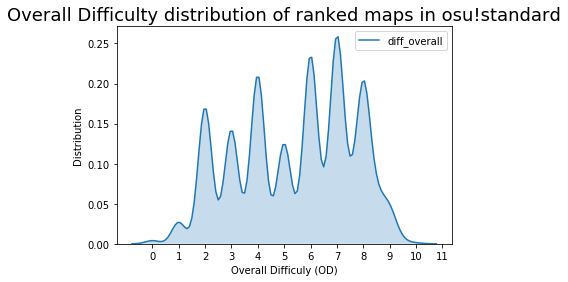

In [164]:
analyzeOD(getDataFrame('standard'), tight=False)

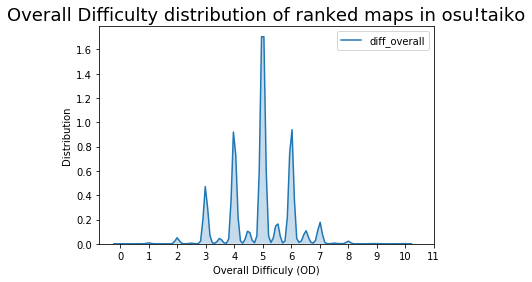

In [156]:
analyzeOD(getDataFrame('taiko'), tight=True)

C:\Users\camen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


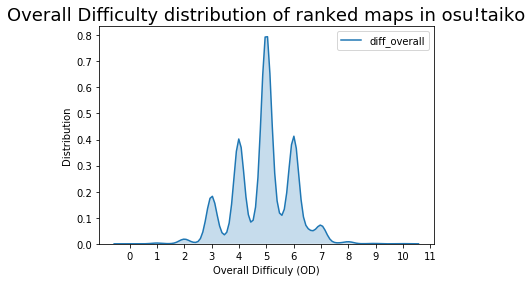

In [157]:
analyzeOD(getDataFrame('taiko'), tight=False)

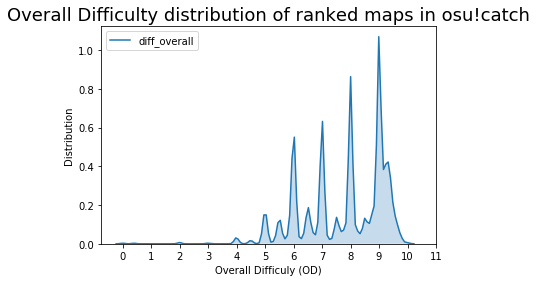

In [158]:
analyzeOD(getDataFrame('catch'), tight=True)

C:\Users\camen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


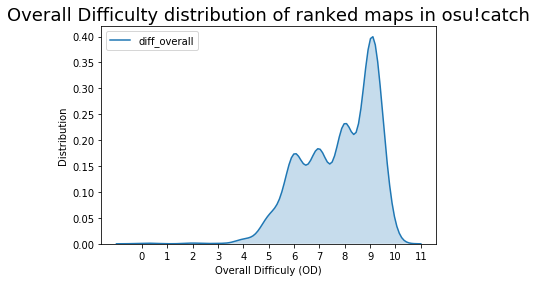

In [159]:
analyzeOD(getDataFrame('catch'), tight=False)

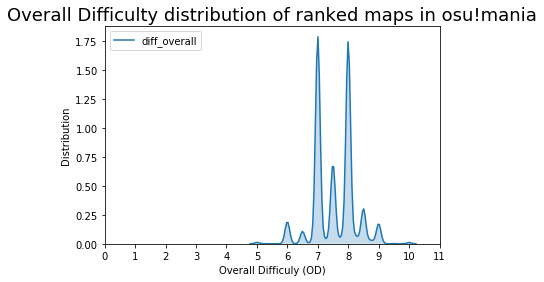

In [160]:
analyzeOD(getDataFrame('mania'), tight=True)

C:\Users\camen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


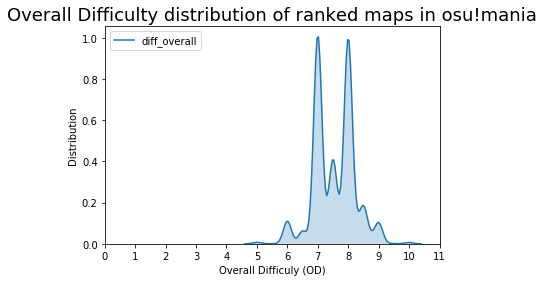

In [161]:
analyzeOD(getDataFrame('mania'), tight=False)

# Approach Rate (AR)

# Healthdrain (HP)

# bpm

# Max Combo